# Outline of the notebook
**Grab data**
- Code that uses `Herbie` to pull HRRR data from AWS, and downloads the grib file locally.

**Use `wgrib` wrapper to subregion the data**
- Uses `Herbie`'s wrapper for `wgrib2` to create a subregion (LA metropolitan area) of the grib data.

**Convert to `xarray` and visualize subregion**
- Converts the grib data into an intermediate format `xarray`, which is used to visualize and validate our subregioned data with different projections.

**`xarray` to `numpy`, and interpolation/decimation**
- Uses `opencv` for decimation of the data from 68x70 into 40x40.

**Creating a filter/Full pipeline: HRRR to ConvLSTM filter**
- Performs the full pipeline of converting the HRRR data into an acceptable input filter for the ConvLSTM.

# Grab data

In [1]:
from herbie import Herbie, wgrib2, paint
from pathlib import Path
import pandas as pd

import xarray as xr
from herbie.toolbox import EasyMap, ccrs, pc

In [2]:
# grab palisades data for smoke
H = Herbie(
    "2025-01-10",
    model="hrrr",
    product="sfc",
    fxx=0,
)

H.download("MASSDEN")

my_file = H.get_localFilePath("MASSDEN")

my_file, my_file.exists()

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'),
 True)

# Use `wgrib` wrapper to subregion the data
While you can download a subset of the data by feature, there is no method in which you can download a subregion. You'll have to first download the subset of features you want, THEN create the subregion. `wgrib2` is a tool created by NOAA self-described as a "tool to read and write grib files"
- https://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/

Herbie doesn't natively support the ability to subregion data, so the authors instead provide a wrapper for this tool; this does mean that you'll have to download `wgrib2` separately. But thankfully, both `herbie` and `wgrib2` can be cleanly downloaded via `conda`.

In [3]:
# Print the standard inventory of a grib2 file
print(wgrib2.inventory(my_file))

1:0:d=2025011000:MASSDEN:8 m above ground:anl:



In [4]:
# Create a standard inventory file

idx_file = wgrib2.create_inventory_file(my_file)

idx_file, idx_file.exists()

(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.idx'),
 True)

In [5]:
wgrib2.vector_relative(my_file)

All winds are grid-relative winds.


{'winds(grid)'}

In [6]:
# Create a regional subset of the file
#lat_bottom, lat_top = 33.28, 34.86
#lon_bottom, lon_top = -119.1, -117.3
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9

extent = (lon_bottom, lon_top, lat_bottom, lat_top)

subset_file = wgrib2.region(my_file, extent, name="la_region")
subset_file

PosixPath('/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2')

In [7]:
# Look at the inventory file again to see it is different 
# from before the region subset
pd.read_csv(str(subset_file) + ".idx", delimiter=":", header=None)

,0,1,2,3,4,5,6
0,1,0,d=2025011000,MASSDEN,8 m above ground,anl,NaN


In [8]:
my_file, subset_file

(PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'),
 PosixPath('/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2'))

# Convert to `xarray` and visualize subregion

## `xarray` conversion

In [9]:
# Get crs from a regular Herbie object
ds = H.xarray("MASSDEN")
crs = ds.herbie.crs

# (can't use Herbie to open FILE yet, so just use xarray)
ds_region = xr.open_dataset(subset_file, engine="cfgrib")

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTime

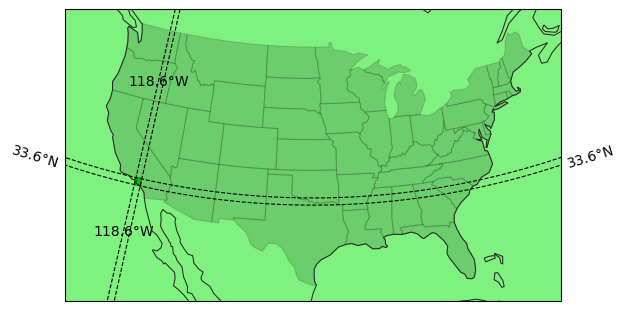

In [10]:
ax = EasyMap(crs=crs).STATES(color="k").ax
ax.pcolormesh(ds.longitude, ds.latitude, ds.mdens, alpha=0.5, transform=pc, **paint.AQIPm25.kwargs2)
ax.pcolormesh(ds_region.longitude, ds_region.latitude, ds_region.mdens, transform=pc, **paint.AQIPm25.kwargs2)

ax.gridlines(xlocs=extent[:2], ylocs=extent[2:], color="k", ls="--", draw_labels=True)

In [11]:
ds

<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 8MB 1.52e-09 1.52e-09 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

In [12]:
ds_region

<xarray.Dataset> Size: 16kB
Dimensions:            (y: 30, x: 26)
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 6kB 33.5 33.51 33.52 ... 34.4 34.41 34.41
    longitude          (y, x) float64 6kB 241.5 241.5 241.5 ... 242.0 242.0
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    mdens              (y, x) float32 3kB 4e-10 6.4e-10 ... 8.855e-26 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-03-28T17:46 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
ds_region['mdens']

<xarray.DataArray 'mdens' (y: 30, x: 26)> Size: 3kB
array([[4.00000e-10, 6.40000e-10, 7.20000e-10, ..., 1.20000e-09, 2.40000e-10,
        2.40000e-10],
       [1.20000e-09, 1.36000e-09, 1.20000e-09, ..., 1.60000e-09, 3.20000e-10,
        3.20000e-10],
       [1.92000e-09, 2.08000e-09, 2.48000e-09, ..., 2.80000e-09, 8.00000e-10,
        4.80000e-10],
       ...,
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26],
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26, 8.85486e-26,
        8.85486e-26]], shape=(30, 26), dtype=float32)
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 6kB 33.5 33.51 33.52 ... 34.4 34.41 34.41
    longitude          (y, x) float64 6kB 241.5 241.5 241.5 ... 242.0 242.0
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_paramId:                             400000
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      780
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Mass density
    GRIB_shortName:                           mdens
    GRIB_units:                               kg m**-3
    long_name:                                Mass density
    units:                                    kg m**-3
    standard_name:                            unknown

## Visualizing
1. Built-in plot function
2. to Plate Carree
3. to Lambert Conical Conformal
4. to Robinson

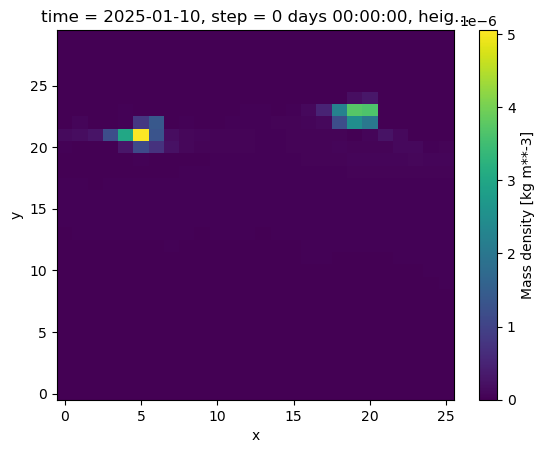

In [14]:
ds_region['mdens'].plot()

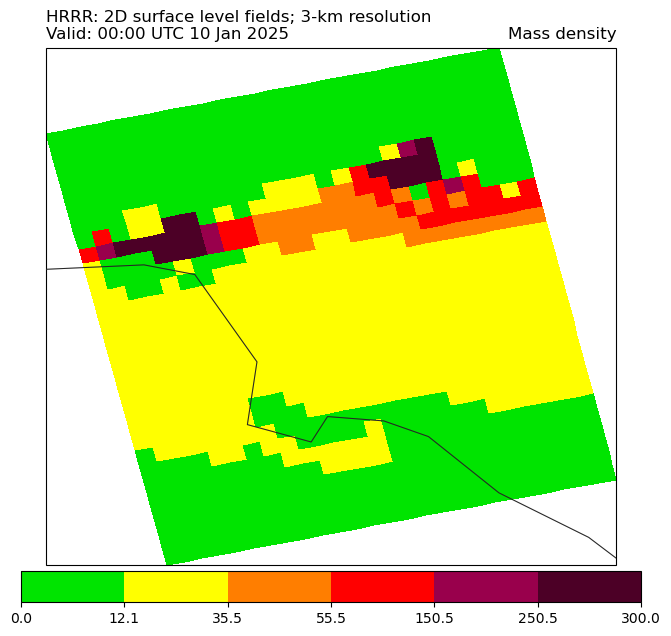

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from herbie.toolbox import EasyMap, pc, ccrs
from herbie import paint

micro_per_kg = 1000000000
def plot(ds, coords=None, save=False, proj=pc, figsize=[10, 8], short_title=False):
    plt.figure()
    ax = EasyMap("50m", crs=proj, figsize=figsize).BORDERS().STATES().ax
    
    if coords != None:
        ax.set_extent(coords)
    
    p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.mdens * micro_per_kg,
        transform=pc,
        **paint.AQIPm25.kwargs2,
    )

    if short_title:
        ax.set_title(
            f"Valid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}\n",
            loc="left",
        )
    else:  
        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            shrink=0.8,
            **paint.AQIPm25.kwargs2,
        )
        ax.set_title(
            f"HRRR: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
            loc="left",
        )
    ax.set_title(ds.mdens.GRIB_name, loc="right")

    if save:
        plt.savefig(f"images/hrrr_viz_{str(int(ds.step.item() / 3600000000000)).zfill(2)}.png")
        
    plt.show()
    plt.clf()

plot(ds_region)

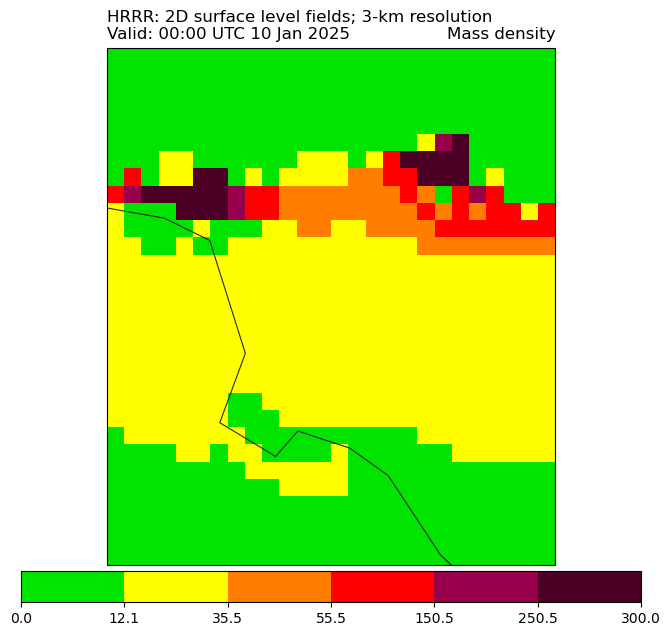

<Figure size 640x480 with 0 Axes>

In [16]:
plot(ds_region, proj=ds.herbie.crs)

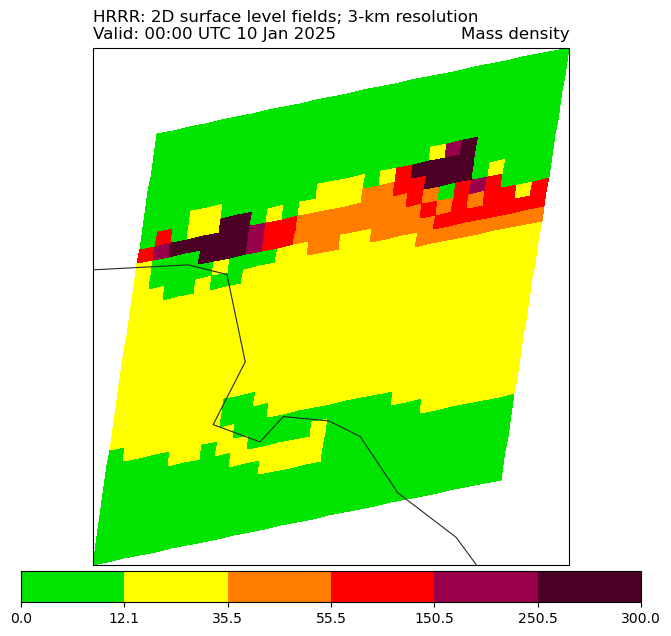

<Figure size 640x480 with 0 Axes>

In [17]:
plot(ds_region, proj=ccrs.Robinson())

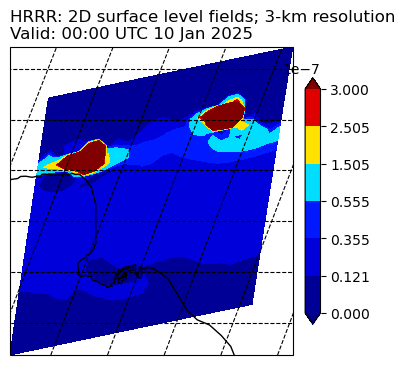

In [18]:
import numpy as np

# attempting to look the same as the pwwb notebook
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Set contour levels, then draw the plot and a colorbar
clevs = [a / micro_per_kg for a in [0, 12.1, 35.5, 55.5, 150.5, 250.5, 300]]
clevs = np.array(np.array(clevs))
plt.contourf(ds_region.longitude, ds_region.latitude, ds_region.mdens, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
#plt.title(sub_ds.mdens.GRIB_name, size=14)
ax.set_title(
    f"HRRR: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
#ax.set_title(ds.mdens.GRIB_name, loc="right")
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

## Thoughts relative to the previous notebook (manual method)
I believe is should be more correct than the manual method I've run in the previous notebook. 

First, I trust a NOAA-developed utility specially designed for grib files than my own code. 

Secondly, the projections on the map seem to make more sense; compare these images to the previous notebook, the way the projections are stretched makes more sense here. 

The logic here is for LCC to Plate Carree, the data bends up like a rainbow; meaning that a subregion on the bottom left of the map should be a diamond, from bottom left to upper right. The image in this notebook is in line with my expectations, while the image in the previous notebook is not.

Meanwhile, for the native LCC projection, the image should definitely be just a square, but that's not the case in the previous notebook.

There is one downside, and that is some attributes are stripped during the subregion phase, because the result is an `xarray` object and not a `Herbie` object; for example, attributes like
```
institution : US National Weather Service - NCEP
model : hrrr
product : sfc
description : High-Resolution Rapid Refresh - CONUS
```
were stripped. This is remedied by keeping the reference to the original datasets pulled by Herbie if you want to refer to such attributes.

Finally, no NaNs are in the array, meaning we don't need to perform any imputation.

# `xarray` to `numpy`, and interpolation/decimation
The goal here is to convert our data to numpy, then use decimation to downsample our 68x70 data to fit into a 40x40 space. Later on, we may consider using interpolation (possibly IDW, though that may be best for only a few points?) to upsample our data into a 200x200 pixel space. 

In [19]:
# xarray has a simple to_numpy() method; just specify the feature.
ds_region_np = ds_region['mdens'].to_numpy()
ds_region_np

array([[4.00000e-10, 6.40000e-10, 7.20000e-10, 6.40000e-10, 1.44000e-09,
        3.92000e-09, 6.72000e-09, 8.72000e-09, 9.28000e-09, 8.96000e-09,
        8.24000e-09, 7.60000e-09, 7.04000e-09, 6.96000e-09, 7.04000e-09,
        7.60000e-09, 7.52000e-09, 7.84000e-09, 5.92000e-09, 8.08000e-09,
        7.60000e-09, 7.52000e-09, 6.56000e-09, 1.20000e-09, 2.40000e-10,
        2.40000e-10],
       [1.20000e-09, 1.36000e-09, 1.20000e-09, 1.68000e-09, 3.28000e-09,
        5.52000e-09, 7.76000e-09, 9.12000e-09, 9.12000e-09, 8.40000e-09,
        7.60000e-09, 7.20000e-09, 7.20000e-09, 7.04000e-09, 7.12000e-09,
        7.52000e-09, 7.76000e-09, 7.68000e-09, 6.88000e-09, 9.04000e-09,
        8.24000e-09, 8.24000e-09, 6.16000e-09, 1.60000e-09, 3.20000e-10,
        3.20000e-10],
       [1.92000e-09, 2.08000e-09, 2.48000e-09, 3.60000e-09, 4.88000e-09,
        6.80000e-09, 8.88000e-09, 9.52000e-09, 8.96000e-09, 8.32000e-09,
        8.08000e-09, 8.24000e-09, 8.48000e-09, 8.40000e-09, 7.92000e-09,
       

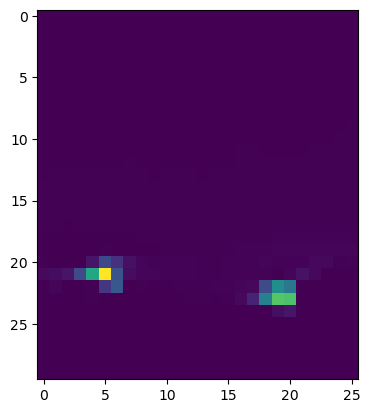

In [20]:
plt.imshow(ds_region_np)

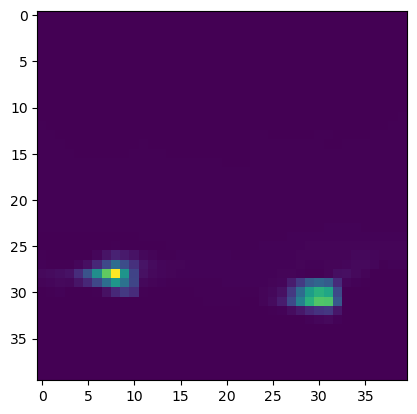

In [21]:
import cv2

out = cv2.resize(ds_region_np, (40, 40))
out = np.reshape(out, (40, 40, 1))
plt.imshow(out[:,:,0])

In [22]:
out.shape

(40, 40, 1)

Without defined color levels, only the worst air visually stands out.

# Creating a filter
Here, we'll download 12 hours of smoke forecasts, apply the necessary transformations to numpy arrays, then create the filter.
- Samples: 1
- Frames: 12
- Rows: 40
- Columns: 40
- Channels: 1

In [23]:
# get 1/10/25 forecast at 00:00 UTC for the next 12 hours
# 00 is assimilated data, then 01->11 will be forecasts
grib_files = []
for i in range(0, 12):
    H = Herbie(
        "2025-01-10-00",
        model="hrrr",
        product="sfc",
        fxx=i
    )
    H.download("MASSDEN")
    my_file = H.get_localFilePath("MASSDEN")
    grib_files.append(my_file)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F05 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F07 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F08 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F10 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

When visualizing I realized that the data comes in (y, x), so you'll actually need to flip the numpy arrays to get the correct image when plotting with numpy.

In [24]:
# validate downloads, subregion each grib file, then convert to numpy arrays
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

hrrr_subregion_np = []
hrrr_subregion_xarr = []
for file in grib_files:
    # examine files, subregion the grib
    print(f"Inventory: {wgrib2.inventory(file)}")
    idx_file = wgrib2.create_inventory_file(file)
    print(f"Index files: {idx_file, idx_file.exists()}")
    subset_file = wgrib2.region(file, extent, name="la_region")
    print(f"Subregion file created: {subset_file}")
    print("--------------------------------------------------------------------------------")

    # store as xarray and numpy
    hrrr_xarr = xr.open_dataset(subset_file, engine="cfgrib")
    hrrr_subregion_xarr.append(hrrr_xarr)
    hrrr_subregion_np.append(np.flip(hrrr_xarr.mdens.to_numpy(), axis=0))

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9e49dd4__hrrr.t00z.wrfsfcf01.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring

Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:anl:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:1 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9e49dd4__hrrr.t00z.wrfsfcf01.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9e49dd4__hrrr.t00z.wrfsfcf01.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:2 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9219dd4__hrrr.t00z.wrfsfcf02.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9219dd4__hrrr.

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9159dd4__hrrr.t00z.wrfsfcf03.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d94b9dd4__hrrr.t00z.wrfsfcf04.grib2.5b7b6.idx' older than GRIB file
/home/mg

Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9159dd4__hrrr.t00z.wrfsfcf03.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:4 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d94b9dd4__hrrr.t00z.wrfsfcf04.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d94b9dd4__hrrr.t00z.wrfsfcf04.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:5 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d91a9dd4__hrrr.t00z.wrfsfcf05.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d91a9dd4__hrrr.t00z.wrfsfcf05.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:6 hour fcst:

Ind

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9c79dd4__hrrr.t00z.wrfsfcf07.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9c59dd4__hrrr.t00z.wrfsfcf08.grib2.5b7b6.idx' older than GRIB file
/home/mg

Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9c79dd4__hrrr.t00z.wrfsfcf07.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:8 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9c59dd4__hrrr.t00z.wrfsfcf08.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9c59dd4__hrrr.t00z.wrfsfcf08.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:9 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d99e9dd4__hrrr.t00z.wrfsfcf09.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d99e9dd4__hrrr.t00z.wrfsfcf09.grib2
--------------------------------------------------------------------------------
Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:10 hour fcst:

In

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9a49dd4__hrrr.t00z.wrfsfcf11.grib2.5b7b6.idx' older than GRIB file


Inventory: 1:0:d=2025011000:MASSDEN:8 m above ground:11 hour fcst:

Index files: (PosixPath('/home/mgraca/data/hrrr/20250110/subset_d9a49dd4__hrrr.t00z.wrfsfcf11.grib2.idx'), True)
Subregion file created: /home/mgraca/data/hrrr/20250110/la_region_subset_d9a49dd4__hrrr.t00z.wrfsfcf11.grib2
--------------------------------------------------------------------------------


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


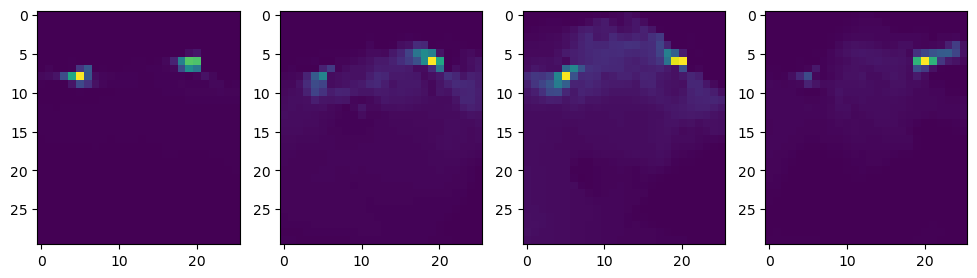

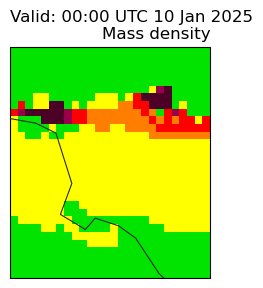

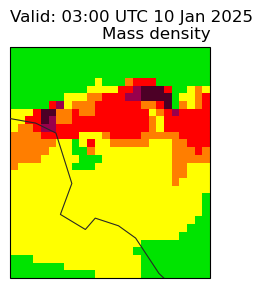

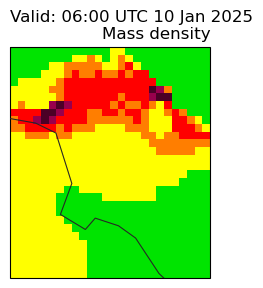

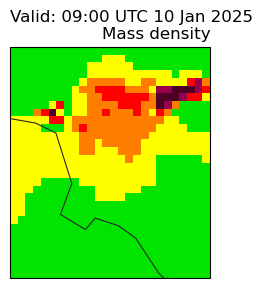

<Figure size 640x480 with 0 Axes>

In [25]:
# validate downloads worked, and compare
# plot out every 4 hours (00, 03, 07, 11)
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
for i in range(0, 12, 3):
    axes[i//3].imshow(hrrr_subregion_np[i])
plt.show()

for i in range(0, 12, 3):
    plot(hrrr_subregion_xarr[i], proj=ds.herbie.crs, figsize=[4, 3], short_title=True)

In [26]:
# decimate and create channel axis
sample = np.empty(shape=(12, 40, 40, 1))

for i, frame in enumerate(hrrr_subregion_np):
    new_frame = cv2.resize(frame, (40, 40))
    new_frame = np.reshape(new_frame, (40, 40, 1)) # (row, col, channel)
    sample[i] = new_frame

# one sample: 12 frames, 40x40, 1 channel
print(sample.shape)

(12, 40, 40, 1)


# Creating multiple samples
- Downloads 120 grib files
- Subsets the grib files
- Converts the grib files into `numpy` arrays
- Scales the data
- Bundles the frames to create muyltiple samples

In [27]:
# downloads 5 days of data (1-10 to 1-14), 24 hours (00 to 23) -> 120 hours
# not forecasts -- downloading actual hourly updated data
grib_files = []
for day in range(10, 15):
    for hour in range(0, 24):
        date = f"2025-01-{str(day).zfill(2)}-{str(hour).zfill(2)}"
        H = Herbie(
            date,
            model="hrrr",
            product="sfc",
        )
        H.download("MASSDEN")
        my_file = H.get_localFilePath("MASSDEN")
        grib_files.append(my_file)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 01:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 04:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 05:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 07:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 10:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

In [28]:
# validate downloads, subregion each grib file, then convert to numpy arrays
lat_bottom, lat_top = 33.28, 34.86
lon_bottom, lon_top = -119.1, -117.3
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

hrrr_subregion_np = np.empty((120, 69, 67))
hrrr_subregion_xarr = []
for count, file in enumerate(grib_files):
    # subregion the grib files
    idx_file = wgrib2.create_inventory_file(file)    
    subset_file = wgrib2.region(file, extent, name="la_region")

    # print progress
    if ((count + 1) % 10 == 0 or count + 1 == len(grib_files)):
        print(f"{count+1}/{len(grib_files)} files converted.")

    # store as xarray and numpy
    hrrr_xarr = xr.open_dataset(subset_file, engine="cfgrib")
    hrrr_subregion_xarr.append(hrrr_xarr)
    hrrr_subregion_np[count] = np.flip(hrrr_xarr.mdens.to_numpy(), axis=0)

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring

10/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_5def9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_5aef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

20/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_34ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_d7ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

30/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_4def9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b0ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

40/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_80ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_6def9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

50/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_d9ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_90ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

60/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_28ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b1ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

70/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_96ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_0fef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

80/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_06ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c4ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

90/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_58ef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_4cef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

100/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_efef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a7ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

110/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a4ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_f8ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
/home/mg

120/120 files converted.


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [29]:
# expects 12 frames to plot
def plot_12(sample):
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    for i in range(0, 4):
        for j in range(0, 3):
            axes[i][j].imshow(sample[i+j])
    plt.show()

Scaled frames: [[-0.06967362 -0.07182206 -0.07182206 ... -0.08041579 -0.08041579
  -0.08041579]
 [-0.07611892 -0.07611892 -0.07397049 ... -0.08041579 -0.08041579
  -0.08041579]
 [-0.07826736 -0.07826736 -0.07611892 ... -0.08041579 -0.08041579
  -0.08041579]
 ...
 [-0.07611892 -0.07611892 -0.07611892 ... -0.08041579 -0.08041579
  -0.08041579]
 [-0.07611892 -0.07611892 -0.07611892 ... -0.07826736 -0.08041579
  -0.08041579]
 [-0.07611892 -0.07611892 -0.07611892 ... -0.07397049 -0.08041579
  -0.08041579]]
Shape of scaled frames: (120, 69, 67)


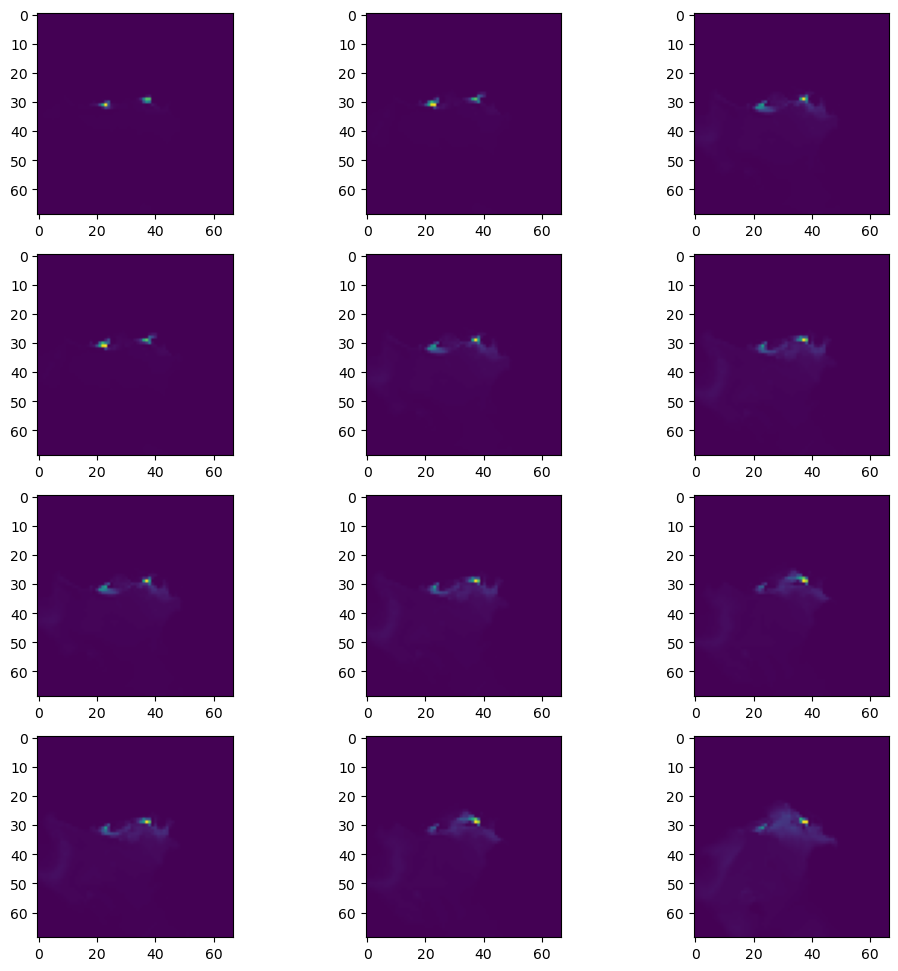

Shape of a frame: (120, 40, 40, 1)


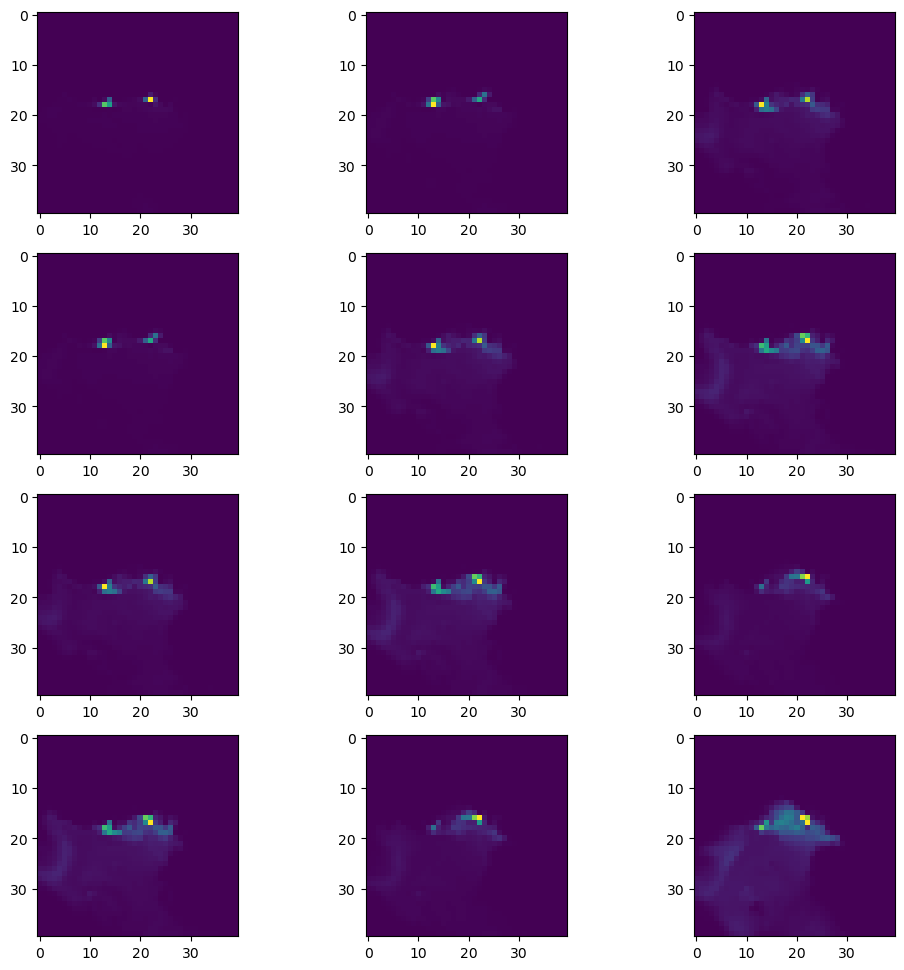

Shape of the input: (108, 12, 40, 40, 1)


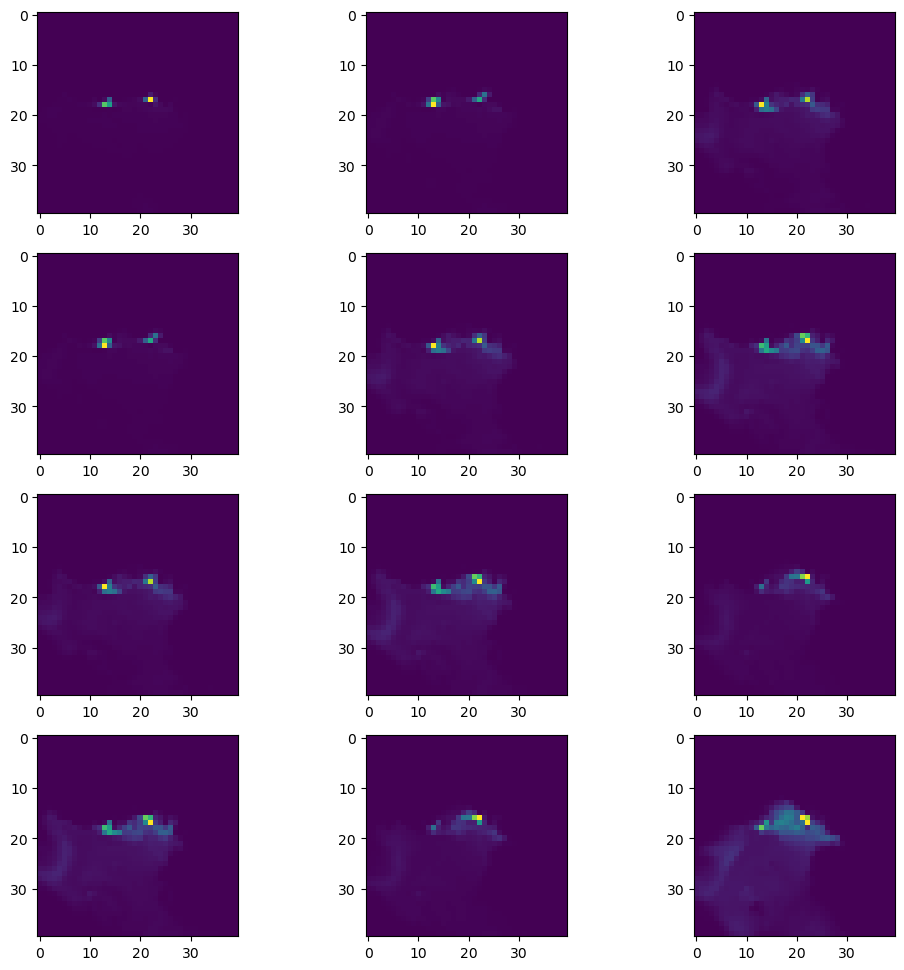

In [30]:
# standard scale data

import math
mean = hrrr_subregion_np.mean()
var = hrrr_subregion_np.var()
scaled_hrrr = (hrrr_subregion_np - mean) / math.sqrt(var)

print(f"Scaled frames: {scaled_hrrr[0]}")
print(f"Shape of scaled frames: {scaled_hrrr.shape}")
plot_12(scaled_hrrr[0:11])

# decimate and create channel axis
frames = np.empty(shape=(120, 40, 40, 1))
for i, frame in enumerate(scaled_hrrr):
    new_frame = cv2.resize(frame, (40, 40))
    new_frame = np.reshape(new_frame, (40, 40, 1)) # (row, col, channel)
    frames[i] = new_frame

print(f"Shape of a frame: {frames.shape}")
plot_12(frames[0:11])

# create samples from frames
sample_size = 12 # aka frames per sample
n_frames = len(scaled_hrrr) # 120
n_samples = n_frames - sample_size # 108
X = np.empty((n_samples, sample_size, 40, 40, 1))
for i in range(n_samples):
    sample = np.array([frames[j] for j in range(i, i + sample_size)])
    X[i] = sample

print(f"Shape of the input: {X.shape}")
plot_12(X[0])

Training data


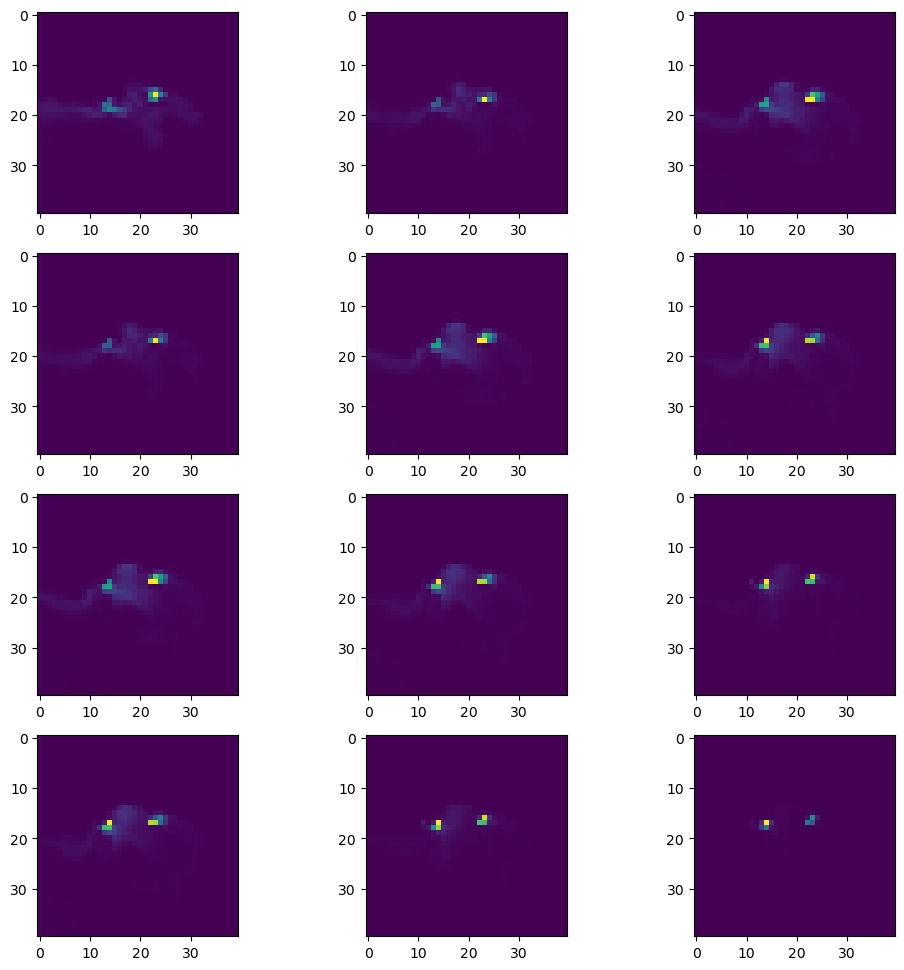

Decimated and scaled


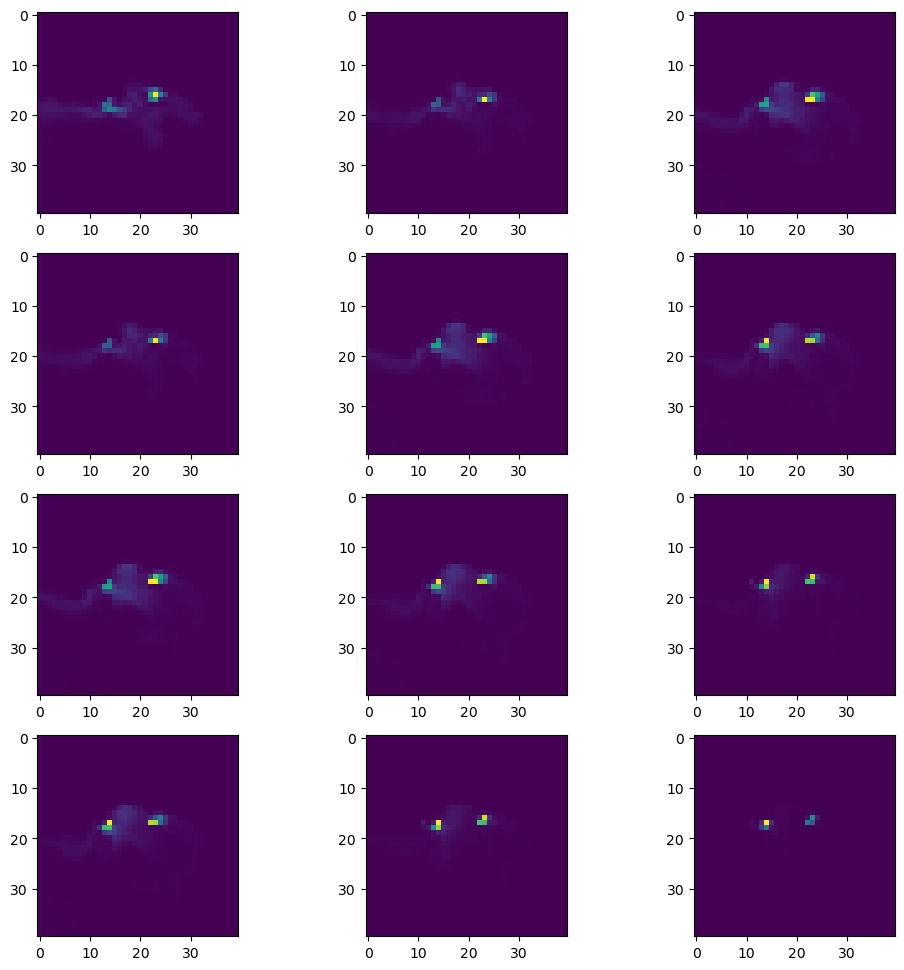

Numpy, directly from grib file


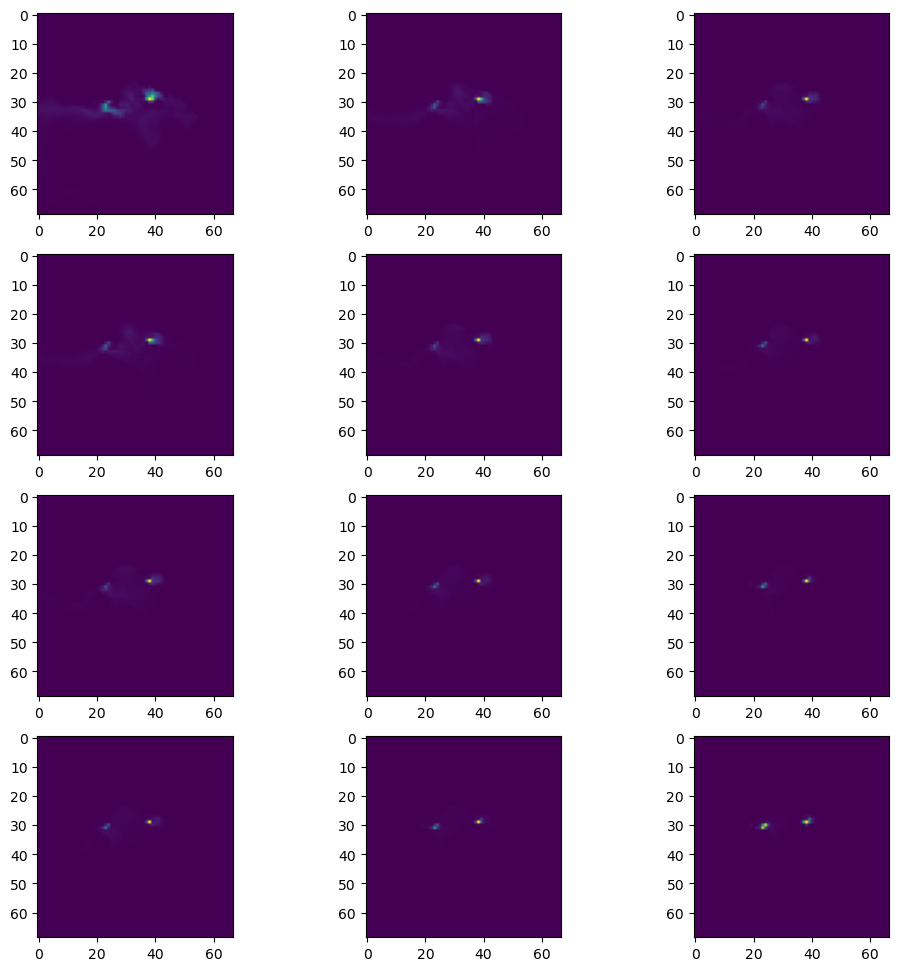

In [31]:
# print a random sample and compare to the actual
# example: sample 16 would correspond to 
# sample 0 -> 0 - 11, sample 1 ->  1 - 12 ... sample 16 -> 16 - 27

# training data
print("Training data")
plot_12(X[16])
# decimated (and scaled) 
print("Decimated and scaled")
plot_12(frames[16:16+11])
# numpy data from grib
print("Numpy, directly from grib file")
plot_12(hrrr_subregion_np[16:16+11])

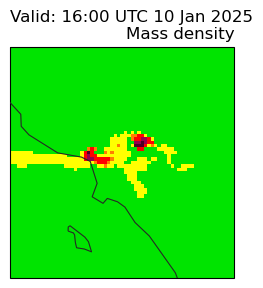

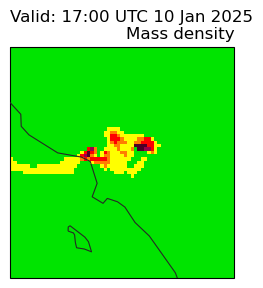

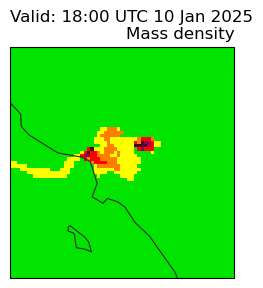

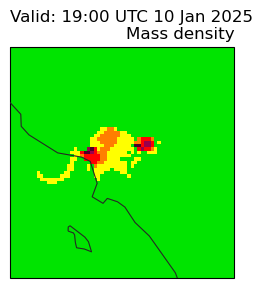

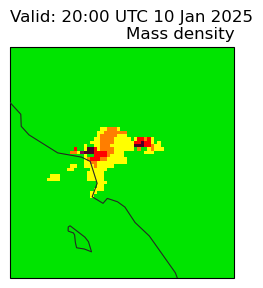

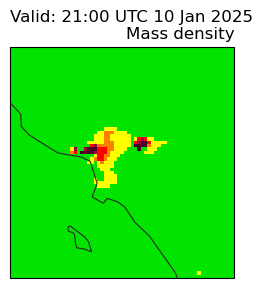

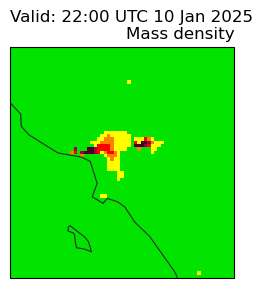

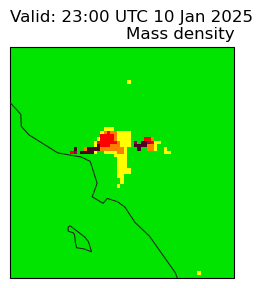

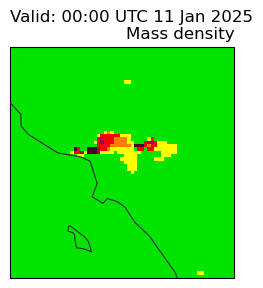

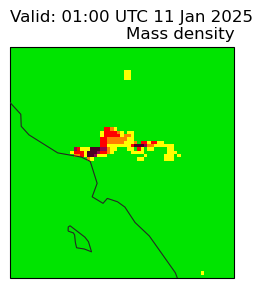

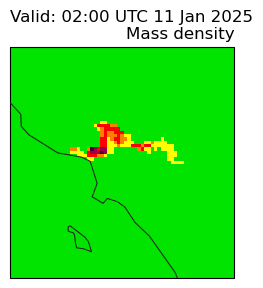

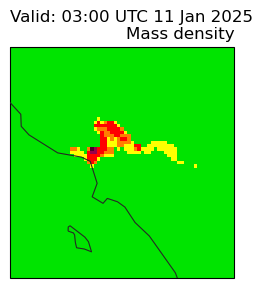

<Figure size 640x480 with 0 Axes>

In [32]:
for i in range(16, 28):
    plot(hrrr_subregion_xarr[i], proj=ds.herbie.crs, figsize=[4, 3], short_title=True)

# Full pipeline: HRRR to ConvLSTM filter
Now that we know we have a validated region, let's try to fit this to our purposes by describing the entire pipeline:
1. Download the 12 hour forecast for the Palisades fire; 12 frames total.
2. Use `herbie`'s `wgrib2` wrapper to subregion the data to the LA metropolitan area for each frame.
3. Convert grib/xarray frames to numpy frames.
4. Interpolate/decimate each frame to fit the desired dimensions (40x40 or 200x200).
5. Fit data to 5D tensors, aka filter: (samples, frames, rows, columns, channels).

# Future additions
- Pipe this input into an actual convlstm
```python
seq = Sequential()

seq.add(ConvLSTM2D(filters=15, kernel_size=(3, 3),
                   # rgb + graph embedding (other 2 from what?)
                   #input_shape=(5, 40, 40, 6),
                   input_shape=(12, 40, 40, 1),
                   padding='same', return_sequences=True))

seq.add(ConvLSTM2D(filters=30, kernel_size=(3, 3),
                   padding='same', return_sequences=True))

seq.add(Conv3D(filters=15, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))


seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))
# only necessary for predicting the 7 AirNow sensors
#seq.add(Flatten())
#seq.add(Dense(7,activation='relu'))
seq.compile(loss='mean_absolute_error', optimizer='adam')
```
- We may be using 200x200 filters: consider something like this to interpolate (basically just zooms into the data). Not a fan of IDW since it seems to be more useful for very sparse input (e.g. a 40x40 grid with only 7 values, like the AirNow sensors). It seems insanely computationally expensive for dense grids like the one I'm using. You can also look into something like `RegularGridInterpolator`.
```python
from scipy.ndimage import zoom

# Example 68x70 grid of PM2.5 values
pm25 = np.random.rand(68, 70)  # Replace this with your actual data

# Calculate the zoom factors
zoom_factors = (200 / 68, 200 / 70)

# Interpolate to the new 200x200 grid
pm25_new = zoom(pm25, zoom_factors, order=1)  # order=1 for linear, order=3 for cubic
```